# PyTorch Regression



In [42]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
torch.__version__

'2.1.0+cu121'

## 1. Data (preparing and loading)

In [43]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

### Split data into training and test sets 

In [44]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing 
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [45]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

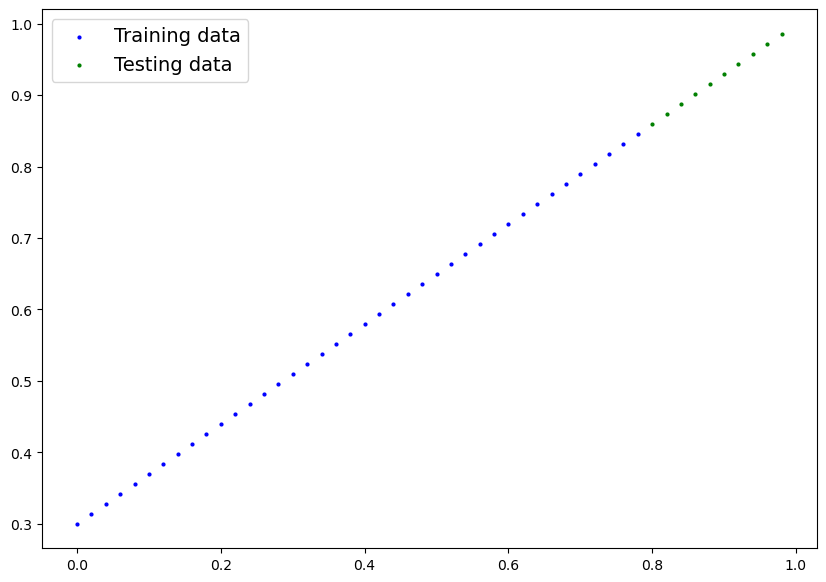

In [46]:
plot_predictions();

# Model initilization

## Linear Regression

$ \hat{y} = x^\top w + b$

## Loss functions

### Root mean squared error

$ \mathcal{L}_{RMSE} = \sqrt{\frac{1}{2 * N} \sum_{i = 1}^N (y_{i}  - \hat{y}_{i} ) ^ 2} $

### Mean absolute error

$ \mathcal{L}_{MAE} = \frac{1}{2 * N} \sum_{i = 1}^N | y_{i}  - \hat{y}_{i}| $

## L1 reg

$ \mathcal{L}_{l1} = \mathcal{L} +  \frac{\lambda}{2} \sum_{j = 1}^M |w_j|$

## L2 reg

$ \mathcal{L}_{l2} = \mathcal{L} +  \frac{\lambda}{2} \sum_{j = 1}^M w_j ^2$

## Tasks
1. Implement linear regression using the formulas above;
2. Implement RMSE and MAE (you can use both for optimization)

## Notes:
1. The `nn.Module` registeres a forward pass hook based on whatever `forward` method you define. Do not forget to call the super constructor, as your `Module` will not work properly!
2. You can later call it as a python function, e.g. `model(*args, **kwargs)`, based on your `forward` implementation.
3. For the loss function you can either use your own implementation, or the one provided from PyTorch ([Losses](https://pytorch.org/docs/stable/_modules/torch/nn/modules/loss.html)).
4. Do not use the `nn.Linear` to define your parameters for this assignment, albeit in practice it is more convinient!
5. You'll most probabily need to check the `torch.nn.Parameter`'s documentation.


In [47]:
class LinearRegression(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=in_features, 
                                      out_features=1)
    
    def forward(self, x):
        return self.linear_layer(x)

model = LinearRegression(X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

torch.manual_seed(42)

mse = nn.MSELoss()
mae = nn.L1Loss()
list(model.parameters())

[Parameter containing:
 tensor([[-0.2343]], requires_grad=True),
 Parameter containing:
 tensor([0.9186], requires_grad=True)]

We can also get the state (what the model contains) of the model using [`.state_dict()`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.state_dict).

In [48]:
model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[-0.2343]])),
             ('linear_layer.bias', tensor([0.9186]))])

In [49]:
with torch.inference_mode(): 
    y_preds = model(X_test)


In [50]:
print(f"Number of testing samples: {len(X_test)}")
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.7312],
        [0.7265],
        [0.7218],
        [0.7171],
        [0.7125],
        [0.7078],
        [0.7031],
        [0.6984],
        [0.6937],
        [0.6890]])


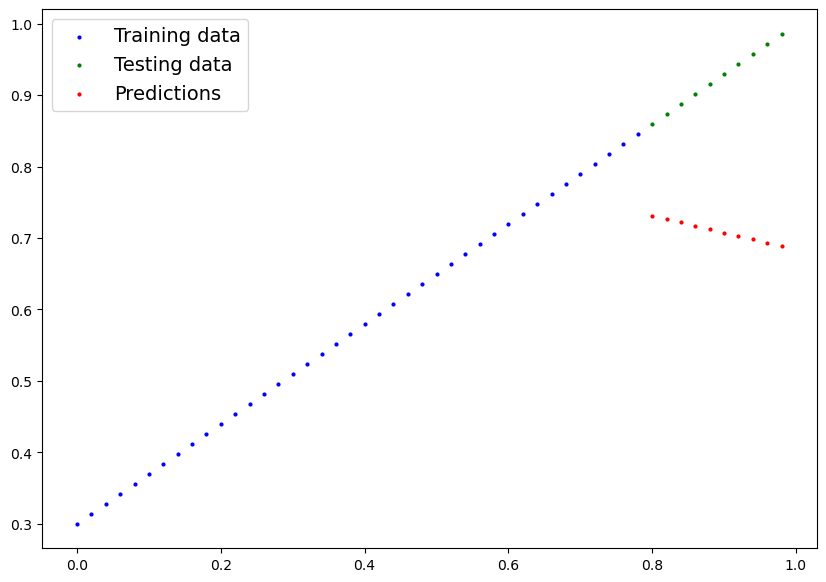

In [51]:
plot_predictions(predictions=y_preds)

In [52]:
y_test - y_preds

tensor([[0.1288],
        [0.1475],
        [0.1662],
        [0.1849],
        [0.2035],
        [0.2222],
        [0.2409],
        [0.2596],
        [0.2783],
        [0.2970]])

## 3. Train model

In [53]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model.parameters(), # parameters of target model to optimize
                            lr=0.01) # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))

In [54]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 100

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model.train()

    # 1. Forward pass on train data using the forward() method inside 
    y_pred = model(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.27326732873916626 | MAE Test Loss: 0.22141309082508087 
Epoch: 10 | MAE Train Loss: 0.23704764246940613 | MAE Test Loss: 0.28700318932533264 
Epoch: 20 | MAE Train Loss: 0.2169996052980423 | MAE Test Loss: 0.3319464921951294 
Epoch: 30 | MAE Train Loss: 0.20525319874286652 | MAE Test Loss: 0.3605498969554901 
Epoch: 40 | MAE Train Loss: 0.19732365012168884 | MAE Test Loss: 0.3797074258327484 
Epoch: 50 | MAE Train Loss: 0.19156280159950256 | MAE Test Loss: 0.39098840951919556 
Epoch: 60 | MAE Train Loss: 0.18687066435813904 | MAE Test Loss: 0.3966142237186432 
Epoch: 70 | MAE Train Loss: 0.18274374306201935 | MAE Test Loss: 0.3994213342666626 
Epoch: 80 | MAE Train Loss: 0.1789170354604721 | MAE Test Loss: 0.39805349707603455 
Epoch: 90 | MAE Train Loss: 0.17538896203041077 | MAE Test Loss: 0.39390242099761963 


Oh would you look at that! Looks like our loss is going down with every epoch, let's plot it to find out.

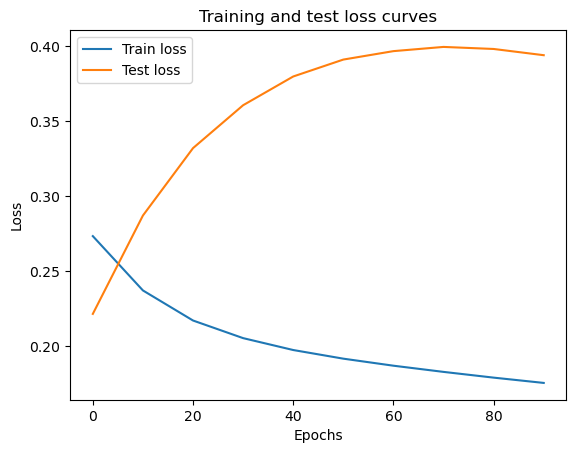

In [55]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [56]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[-0.1503]])), ('linear_layer.bias', tensor([0.6666]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


In [57]:
model.eval()

with torch.inference_mode():

  y_preds = model(X_test)
y_preds

tensor([[0.5464],
        [0.5434],
        [0.5403],
        [0.5373],
        [0.5343],
        [0.5313],
        [0.5283],
        [0.5253],
        [0.5223],
        [0.5193]])

Nice! We've made some predictions with our trained model, now how do they look?

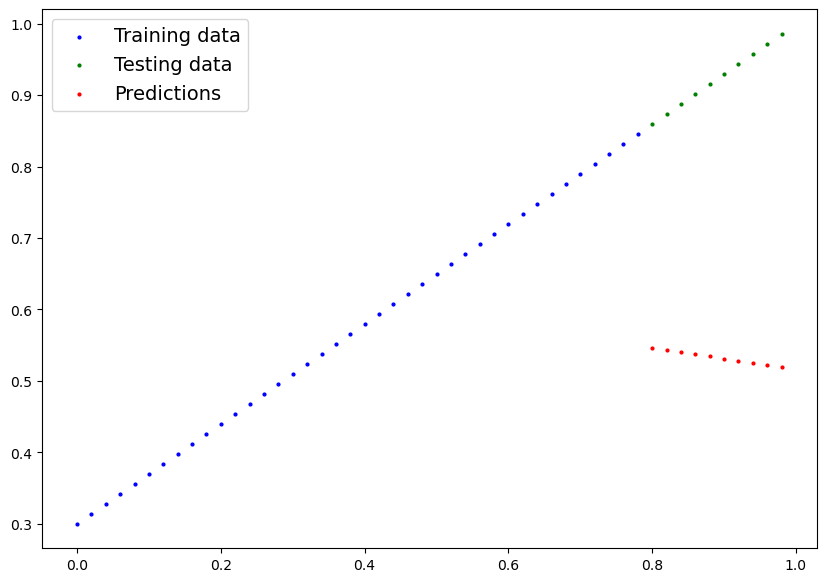

In [58]:
plot_predictions(predictions=y_preds)

## Saving and loading a PyTorch model



In [59]:
MODEL_PATH = ""

MODEL_NAME = "model"
MODEL_SAVE_PATH = MODEL_PATH + MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH) 

Saving model to: model


In [60]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model = LinearRegression(X_train.shape[1])

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [61]:
# 1. Put the loaded model into evaluation mode
loaded_model.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model(X_test) # perform a forward pass on the test data with the loaded model

In [62]:
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

In [63]:
# Import PyTorch and matplotlib
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.1.0+cu121'

In [29]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


Excellent, let's visualize them to make sure they look okay.

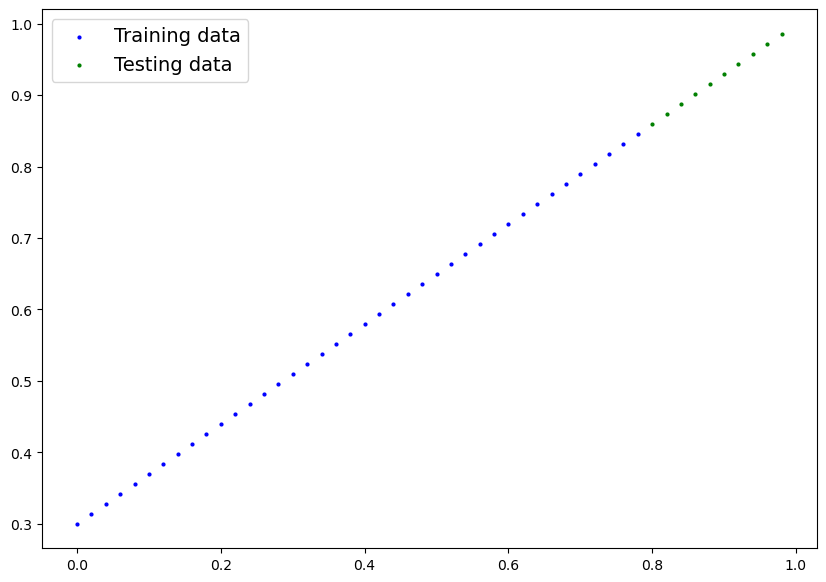

In [30]:
# Note: If you've reset your runtime, this function won't work, 
# you'll have to rerun the cell above where it's instantiated.
plot_predictions(X_train, y_train, X_test, y_test)

In [31]:
# Subclass nn.Module to make our model
class LinearRegressionV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1, 
                                      out_features=1)
    
    def forward(self, x):
        return self.linear_layer(x)

torch.manual_seed(42)
model_1 = LinearRegressionV2()
model_1, model_1.state_dict()

(LinearRegressionV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [32]:
next(model_1.parameters()).device

device(type='cpu')

In [33]:
model_1.to(device) 
next(model_1.parameters()).device

device(type='cuda', index=0)

### 6.3 Training

In [34]:
# Create loss function
loss_fn = nn.L1Loss()

# Create optimizer
optimizer = torch.optim.AdamW(params=model_1.parameters(),
                              lr=0.01)

In [35]:
torch.manual_seed(42)

# Set the number of epochs 
epochs = 1000 

# Put data on the available device
# Without this, error will happen (not all model/data on device)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_1.train() # train mode is on by default after construction

    # 1. Forward pass
    y_pred = model_1(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad optimizer
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model_1.eval() # put the model in evaluation mode for testing (inference)
    # 1. Forward pass
    with torch.inference_mode():
        test_pred = model_1(X_test)
    
        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.5551779866218567 | Test loss: 0.5683961510658264
Epoch: 100 | Train loss: 0.014988399110734463 | Test loss: 0.02836630307137966
Epoch: 200 | Train loss: 0.002427533967420459 | Test loss: 0.0032408477272838354
Epoch: 300 | Train loss: 0.0014569759368896484 | Test loss: 0.0015379845863208175
Epoch: 400 | Train loss: 0.0011451520258560777 | Test loss: 0.001745206187479198
Epoch: 500 | Train loss: 0.0012770943576470017 | Test loss: 0.00029595496016554534
Epoch: 600 | Train loss: 0.00023325905203819275 | Test loss: 0.002654093550518155
Epoch: 700 | Train loss: 0.0014367826515808702 | Test loss: 0.001246458268724382
Epoch: 800 | Train loss: 0.00023701861209701747 | Test loss: 6.196498725330457e-05
Epoch: 900 | Train loss: 0.00048023610725067556 | Test loss: 0.0008219123119488358


In [36]:
from pprint import pprint 
print("The model learned the following values for weights and bias:")
pprint(model_1.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.7021]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3015], device='cuda:0'))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


In [37]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([[0.8632],
        [0.8772],
        [0.8913],
        [0.9053],
        [0.9194],
        [0.9334],
        [0.9475],
        [0.9615],
        [0.9755],
        [0.9896]], device='cuda:0')

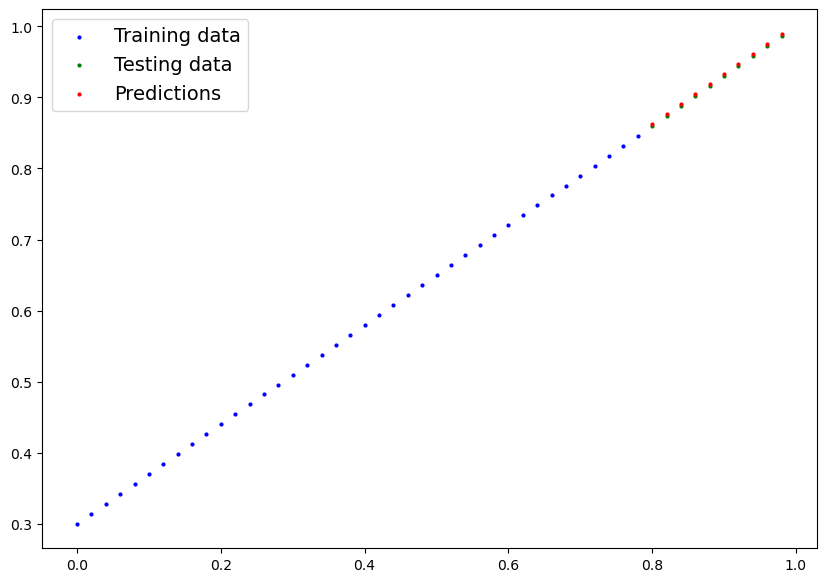

In [38]:
plot_predictions(predictions=y_preds.cpu())

In [39]:
MODEL_PATH = ""

MODEL_NAME = "model"
MODEL_SAVE_PATH = MODEL_PATH + MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), 
           f=MODEL_SAVE_PATH) 

Saving model to: model


In [40]:
loaded_model_1 = LinearRegressionV2()

loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

loaded_model_1.to(device)

print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")

Loaded model:
LinearRegressionV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
cuda:0


In [41]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')